# dog-breed-identification : 
# linear model on top of convolution layers of pretrained models

# Keras 2.0 TF backend

# v3 : tests on Inception 

## - transfer learning, data augmentation (use of generators only)

In [169]:
import os, sys
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random, permutation

import pandas as pd

from glob import glob
import shutil
from shutil import move, copyfile
from distutils.dir_util import copy_tree


from keras.applications import vgg16

from keras.applications.resnet50 import ResNet50


from keras.applications import xception
from keras.applications.inception_v3 import InceptionV3

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation,BatchNormalization,GlobalAveragePooling2D, Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2#, activity_l2
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import sklearn
from sklearn.metrics import confusion_matrix

#input_tensor = Input(shape=(3,224,224)) #Theano backend
#input_tensor = Input(shape=(224,224,3)) #TF backend

In [2]:
!pwd

/home/gael/Bureau/kaggle/dog-breed-identification


In [26]:
#os.chdir('..') 

In [3]:
HOME_DIR = os.getcwd()
HOME_DIR   # should be ~/.../dog-breed-identification

'/home/gael/Bureau/kaggle/dog-breed-identification'

In [4]:
DATA_HOME_DIR = HOME_DIR + '/data'
DATA_HOME_DIR

'/home/gael/Bureau/kaggle/dog-breed-identification/data'

In [5]:
%cd $DATA_HOME_DIR

/home/gael/Bureau/kaggle/dog-breed-identification/data


# 1. Data organization for Keras framework

## start from basic structure:
        
    /data
        labels.csv
        /train
        /test
    
## build:

    /data
        /train
            /[120 categories]
        /test
            /unknown
        /results
        /valid
            /[120 categories]
        
        /sample
            /train
                /[10 categories]
            /valid
                /[10 categories]
            /results
            /test

## 1.1. Data inspection / define categories

In [6]:
labels=pd.read_csv('labels.csv')

In [7]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


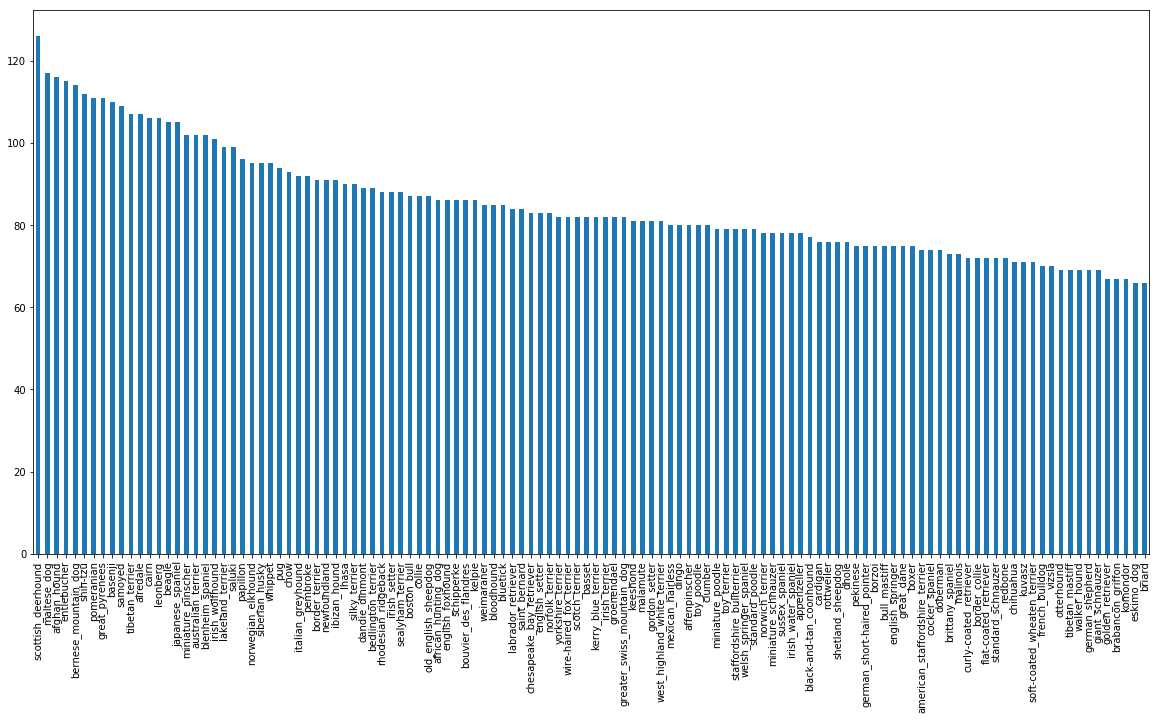

In [8]:
labels['breed'].value_counts().plot(kind='bar', figsize=(20,10))

### list of 120 categories for /data/train and /data/valid

In [9]:
#alphabetical list of breeds
alpha_breed_list = list(labels['breed'].value_counts().index.sort_values('breed')[0])
alpha_breed_list[0]

'affenpinscher'

### list of top 10 categories for /data/sample/train and /data/sample/valid directories

In [10]:
top_ten_cat = labels['breed'].value_counts().index[0:10]
top_ten_cat

Index([u'scottish_deerhound', u'maltese_dog', u'afghan_hound', u'entlebucher',
       u'bernese_mountain_dog', u'shih-tzu', u'pomeranian', u'great_pyrenees',
       u'basenji', u'samoyed'],
      dtype='object')

## 1.2. Make directories / copy and move files 

### make directories : /valid --- /results --- /sample/train ---  /sample/valid

In [11]:
if not os.path.exists(DATA_HOME_DIR + '/valid/'): os.mkdir(DATA_HOME_DIR + '/valid/')
if not os.path.exists(DATA_HOME_DIR + '/results/'): os.mkdir(DATA_HOME_DIR + '/results/')
if not os.path.exists(DATA_HOME_DIR + '/sample/'): os.mkdir(DATA_HOME_DIR + '/sample/')
if not os.path.exists(DATA_HOME_DIR + '/sample/train/'): os.mkdir(DATA_HOME_DIR + '/sample/train/')
if not os.path.exists(DATA_HOME_DIR + '/sample/test/'): os.mkdir(DATA_HOME_DIR + '/sample/test/')
if not os.path.exists(DATA_HOME_DIR + '/sample/valid/'): os.mkdir(DATA_HOME_DIR + '/sample/valid/')
if not os.path.exists(DATA_HOME_DIR + '/sample/results/'): os.mkdir(DATA_HOME_DIR + '/sample/results/')

### move 10% of /train to /valid

In [12]:
from glob import glob

In [13]:
%cd $DATA_HOME_DIR/train
g = glob('*.jpg')
shuf = np.random.permutation(g)

/home/gael/Bureau/kaggle/dog-breed-identification/data/train


In [14]:
#first 10% of shuffled files
valid_samples = shuf[:len(shuf)//10]
train_samples = shuf[len(shuf)//10:]

In [15]:
#lists of train and valid image IDs
valid_samples_id = [valid_samples[i][:-4] for i in range(len(valid_samples))]
train_samples_id = [train_samples[i][:-4] for i in range(len(train_samples))]

In [16]:
#dataFrames containing train_samples and valid_samples
labels_train = labels[labels['id'].isin(train_samples_id)]
labels_valid = labels[labels['id'].isin(valid_samples_id)]

In [17]:
import shutil
from shutil import move, copyfile

In [31]:
for i in range (len(shuf)//10):
    shutil.move(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])
#os.chdir('..')  

In [32]:
%ls $DATA_HOME_DIR/train | wc -l

9200


In [33]:
%ls $DATA_HOME_DIR/valid | wc -l

1022


### create 120 category subdirectories in /train and /valid

In [34]:
#create directories for ea. subcategory
for i in range(len(alpha_breed_list)):
    if not os.path.exists(DATA_HOME_DIR + '/train/' + alpha_breed_list[i]): 
        os.mkdir(DATA_HOME_DIR + '/train/' + alpha_breed_list[i])
    if not os.path.exists(DATA_HOME_DIR + '/valid/' + alpha_breed_list[i]): 
        os.mkdir(DATA_HOME_DIR + '/valid/' + alpha_breed_list[i])

### move files in their category directories 

In [35]:
%cd $DATA_HOME_DIR/train

/home/gael/Bureau/kaggle/dog-breed-identification/data/train


In [36]:
#put each image from training set in its category
for i in range(len(labels_train.index)):
    shutil.move(labels_train.values[i][0]+'.jpg', './'+labels_train.values[i][1]+'/'+labels_train.values[i][0]+'.jpg')

In [37]:
%cd $DATA_HOME_DIR/valid

/home/gael/Bureau/kaggle/dog-breed-identification/data/valid


In [38]:
#put each image from valid set in its category
for i in range(len(labels_valid.index)):
    shutil.move(labels_valid.values[i][0]+'.jpg', './'+labels_valid.values[i][1]+'/'+labels_valid.values[i][0]+'.jpg')

### make test/unknown directory, move test files

In [39]:
%cd $DATA_HOME_DIR/test

/home/gael/Bureau/kaggle/dog-breed-identification/data/test


In [40]:
if not os.path.exists(DATA_HOME_DIR + '/test/unknown/'): 
        os.mkdir(DATA_HOME_DIR + '/test/unknown/')

In [41]:
%cd $DATA_HOME_DIR/test/unknown

/home/gael/Bureau/kaggle/dog-breed-identification/data/test/unknown


In [42]:
!mv $DATA_HOME_DIR/test/*.jpg .

## Copy sample files

### copy top10 categories directories to /sample/train and /sample/valid 

In [43]:
from distutils.dir_util import copy_tree

In [44]:
%cd $DATA_HOME_DIR/train

/home/gael/Bureau/kaggle/dog-breed-identification/data/train


In [45]:
for i in range(len(top_ten_cat[:10])):
    copy_tree(DATA_HOME_DIR + '/train/' + top_ten_cat[i], DATA_HOME_DIR + '/sample/train/' + top_ten_cat[i])
    copy_tree(DATA_HOME_DIR + '/valid/' + top_ten_cat[i], DATA_HOME_DIR + '/sample/valid/' + top_ten_cat[i])

### copy 10% of test/unknown into sample/test/unknown 

In [46]:
%cd $DATA_HOME_DIR/test/unknown
g = glob('*.jpg')
shuf = np.random.permutation(g)

/home/gael/Bureau/kaggle/dog-breed-identification/data/test/unknown


In [47]:
if not os.path.exists(DATA_HOME_DIR + '/sample/test/unknown/'): 
        os.mkdir(DATA_HOME_DIR + '/sample/test/unknown/')

In [48]:
#first 10% of shuffled files
test_samples = shuf[:len(shuf)//10]

In [49]:
%cd $DATA_HOME_DIR/test/unknown
for i in range (len(shuf)//10):
    shutil.copyfile(shuf[i], DATA_HOME_DIR + '/sample/test/unknown/' + shuf[i])

/home/gael/Bureau/kaggle/dog-breed-identification/data/test/unknown


# Paths

In [18]:
%cd $DATA_HOME_DIR

/home/gael/Bureau/kaggle/dog-breed-identification/data


In [19]:
#full dataset
#path, test_path, output_dim = DATA_HOME_DIR + '/', DATA_HOME_DIR +'/test/', 120

#sample dataset
path, test_path, output_dim = DATA_HOME_DIR + "/sample/", DATA_HOME_DIR +'/sample/test/', 10

model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [20]:
model_path

'/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/models/'

In [21]:
test_path

'/home/gael/Bureau/kaggle/dog-breed-identification/data/sample/test/'

# 2. 224x224 models

In [22]:
def write_submission_file(test_probs, model_name, clip_value = 0):
    filenames_df = pd.DataFrame(test_batches.filenames)
    #remove 'unknown/' and '.jpg' from filenames strings
    filenames_extracts = []
    for i in range(len(filenames_df)): filenames_df[0][i] = filenames_df[0][i][filenames_df[0][i].find('/') + 1:-4]

    probs_df = pd.DataFrame(test_probs)
    probs_df_clip = probs_df.clip(clip_value, 1 - clip_value)
    subm_df = pd.concat([filenames_df, probs_df_clip], axis=1)
    header = train_batches.class_indices.keys()
    header = sorted(header)#.sort()
    header.insert(0,'id')
    subm_df.columns = header
    subm_df = subm_df.sort_values(by='id')
    %cd $HOME_DIR
    subm_df.to_csv('submission_'+model_name+'.csv', sep=',', index = False, float_format='%.17f')

In [23]:
def get_features(conv_model, input_tensor, data, include_top = False, batch_size = 8):
    model = conv_model(include_top = include_top, weights = 'imagenet', input_tensor = input_tensor)
    start = time.time()
    features = model.predict(data, batch_size = batch_size)
    end = time.time()
    print(end - start)get_features
    return features

# 3. 299x299 models

In [24]:
input_tensor = Input(shape=(299,299,3))

In [46]:
batch_size = 12

### validation set batches

In [47]:
valid_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

valid_batches = valid_datagen.flow_from_directory(
        path + 'valid',
        target_size = (299,299),
        batch_size = batch_size,
        class_mode=None,
        shuffle=False)

Found 120 images belonging to 10 classes.


### training set batches

In [54]:
train_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

train_batches = train_datagen.flow_from_directory(
        path + 'train',
        target_size = (299,299),
        batch_size = batch_size,
        class_mode = None,
        shuffle = False)

Found 1021 images belonging to 10 classes.


## 3.1. Inception :  linear model on top of features 

In [28]:
conv_model_inception_v3 = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [29]:
valid_batches.n

120

In [30]:
train_batches.n

1021

In [112]:
batch_size = 12

In [57]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data

#steps: Total number of steps (batches of samples) to yield from generator before stopping.
inception_bottleneck_features_train = conv_model_inception_v3.predict_generator(train_batches, 
                                                                      steps = train_batches.n // batch_size,
                                                                      verbose = 1)

504.429939985


In [58]:
bottleneck_features_train.shape

(1020, 8, 8, 2048)

In [62]:
inception_bottleneck_features_valid = conv_model_inception_v3.predict_generator(valid_batches, 
                                                                      steps = valid_batches.n // batch_size,
                                                                      verbose = 1)# valid_batches.n // batch_size)#53s

10/10 [==============================] - 55s    
55.561809063


In [63]:
inception_bottleneck_features_valid.shape#(9200, 8, 8, 2048)

(120, 8, 8, 2048)

### labels

In [87]:
from keras.utils import to_categorical
valid_label = to_categorical(valid_batches.classes, num_classes=output_dim)
train_label = to_categorical(train_batches.classes, num_classes=output_dim)

In [207]:
train_label[:-1].shape #pour correspondre à bottleneck_features_train.shape = (1020, 8, 8, 2048)

(1020, 10)

In [70]:
opt = RMSprop(lr=0.0001)#, rho=0.7)
#opt = Adam(1e-4)

In [71]:
inception_bottleneck_features_train.shape[:]

(1020, 8, 8, 2048)

In [143]:
inception_bottleneck_features_train = bottleneck_features_train
inception_bottleneck_features_valid = bottleneck_features_valid

In [163]:
top_model = Sequential([
        Flatten(input_shape = inception_bottleneck_features_train.shape[1:]),
        #Dropout(0.5),
        #Dense(128, activation='relu'),
        #Dropout(0.5),
        Dense(output_dim, activation='softmax')
        ])
top_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [164]:
batch_size = 128  #64

In [165]:
top_model.fit(inception_bottleneck_features_train, train_labels[:-1], epochs = 10, batch_size = batch_size, 
                 validation_data = (inception_bottleneck_features_valid, valid_labels))

Train on 1020 samples, validate on 120 samples
Epoch 1/10
1020/1020 [==============================] - 1s - loss: 1.1462 - acc: 0.6931 - val_loss: 0.1671 - val_acc: 0.9417
Epoch 2/10
1020/1020 [==============================] - 0s - loss: 0.0318 - acc: 0.9941 - val_loss: 0.1170 - val_acc: 0.9583
Epoch 3/10
1020/1020 [==============================] - 0s - loss: 0.0122 - acc: 1.0000 - val_loss: 0.1079 - val_acc: 0.9750
Epoch 4/10
1020/1020 [==============================] - 0s - loss: 0.0081 - acc: 1.0000 - val_loss: 0.1077 - val_acc: 0.9667
Epoch 5/10
1020/1020 [==============================] - 0s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.1047 - val_acc: 0.9750
Epoch 6/10
1020/1020 [==============================] - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.1147 - val_acc: 0.9583
Epoch 7/10
1020/1020 [==============================] - 0s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.1125 - val_acc: 0.9667
Epoch 8/10
1020/1020 [==============================] - 0s - loss: 0.0017 - ac

In [89]:
top_model.save_weights(model_path+'inc_bottleneck_K2-v3.h5')

In [90]:
top_model.load_weights(model_path+'inc_bottleneck_K2-v3.h5')

### predict a set (directory) of test images

#### Create a generator w/ class_mode=None (no labels)

In [121]:
#test_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

test_batches = test_datagen.flow_from_directory(
        test_path,
        target_size = (299,299),
        batch_size = 1,
        class_mode = None,
        shuffle = False)
#test_data = np.concatenate([test_data_generator.next() for i in range (test_data_generator.n)])

Found 1035 images belonging to 1 classes.


In [122]:
test_batches.filenames

['unknown/0feb3e06b50cada6f4339058eef8d1b0.jpg',
 'unknown/24ea2e01a7cf3250a0fbc6b5a06f6664.jpg',
 'unknown/1f9d4b33a8a9a2e5838f86fb358f66ea.jpg',
 'unknown/1734b70b47ec49ab9e7dc6a119331ffe.jpg',
 'unknown/32ce805e9a8d4852a87ce159df9fe946.jpg',
 'unknown/7fb2caad62ce4a1183c6c5e4b59e36f2.jpg',
 'unknown/3f1bed041b1e9813d2ec0a7c817f7d44.jpg',
 'unknown/559480c4f3605394f73e102380163ef9.jpg',
 'unknown/5fb134dc248a7b120e4ed4fbf60430bf.jpg',
 'unknown/3e87431ab7b060a3e8cfcca3798a13d8.jpg',
 'unknown/1a87b4a3f8f2e40755200627e3146695.jpg',
 'unknown/7b1fddc813adcb2b3519cb590d82f62e.jpg',
 'unknown/ca723dfb684285be9338d6c621a669df.jpg',
 'unknown/80d3965e4e0a9e300bcba28b1e8a62a1.jpg',
 'unknown/d7a8e33d60c6184bdedf9e2e8865199d.jpg',
 'unknown/1f229393f0607e721466390a81debe1c.jpg',
 'unknown/71583ce27dcb16b8e542a038b3d9762f.jpg',
 'unknown/da5c2cf789b1c60cb778ebe0bc00009b.jpg',
 'unknown/70fd39a40d5c5d0abec22ad9a1e8a3a2.jpg',
 'unknown/5e28538c9fedbbda51221a250ff07e8f.jpg',
 'unknown/042bfeb459

In [125]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
inception_bottleneck_features_test = conv_model_inception_v3.predict_generator(test_batches,
                                                                               test_batches.n,# // batch_size, 
                                                                               verbose = 1)

1035/1035 [==============================] - 512s   


In [126]:
np.save(open('bottleneck_features_test.npy', 'w'),
            inception_bottleneck_features_test)

In [127]:
inception_bottleneck_features_test = np.load('bottleneck_features_test.npy')

In [129]:
test_batches.n

1035

In [132]:
inception_bottleneck_features_test.shape

(1035, 8, 8, 2048)

In [134]:
top_model.predict_classes(inception_bottleneck_features_test)#,batch_size=batch_size)

 960/1035 [==========================>...] - ETA: 0s

array([9, 8, 0, ..., 8, 6, 4])

In [135]:
top_model.predict_proba(inception_bottleneck_features_test)

 960/1035 [==========================>...] - ETA: 0s

array([[  1.96396224e-02,   2.17286441e-02,   1.32535016e-02, ...,
          2.56652292e-02,   2.15470120e-01,   4.51119572e-01],
       [  4.87184757e-03,   6.93862140e-02,   2.07480974e-02, ...,
          4.80484776e-03,   4.57924902e-01,   2.45568946e-01],
       [  2.39258260e-01,   1.65793300e-01,   9.16322991e-02, ...,
          1.26794711e-01,   6.42298087e-02,   6.74392655e-02],
       ..., 
       [  6.83490979e-03,   3.64414006e-02,   2.19709426e-02, ...,
          9.19466664e-04,   9.14869010e-01,   6.44592196e-03],
       [  8.43352100e-05,   1.05539621e-04,   8.56011866e-06, ...,
          1.20029676e-04,   5.42432244e-05,   2.77142408e-05],
       [  5.44496905e-03,   8.50681099e-04,   5.38497046e-03, ...,
          6.24949066e-03,   2.27155834e-02,   3.75966122e-03]], dtype=float32)

In [136]:
# predicted classes
incept_valid_preds = top_model.predict_classes(bottleneck_features_valid, batch_size=batch_size)

# probabilities of being in a given class
incept_valid_probs = top_model.predict_proba(bottleneck_features_valid, batch_size=batch_size)#[:,5]


 12/120 [==>...........................] - ETA: 0s

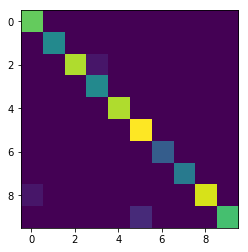

In [137]:
cm = confusion_matrix(incept_valid_preds, valid_batches.classes)
plt.imshow(cm)

In [276]:
write_submission_file(test_probs=incept_test_probs,model_name='Inception', clip_value=0.0)

/home/ubuntu/nbs/dog_breed


## 3.2. Inception : data augmentation + transfer learning

In [192]:
x = conv_model_inception_v3.output
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
out = Dense(output_dim, activation='softmax')(x)

In [193]:
# this is the model we will train
model = Model(inputs=conv_model_inception_v3.input, outputs=out)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in conv_model_inception_v3.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [173]:
train_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input,#rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)#rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                        path + 'train',
                        target_size=(299,299),
                        batch_size=batch_size,
                        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                            path + 'valid',
                            target_size=(299,299),
                            batch_size=batch_size,
                            class_mode='categorical')

Found 1021 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


In [185]:
batch_size = 16

In [186]:
validation_generator.n // batch_size

10

In [187]:
model.fit_generator(#10h52 600s->    // 900s
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/1
85/85 [==============================] - 5485s - loss: 0.4902 - acc: 0.8948 - val_loss: 0.2446 - val_acc: 0.9417


In [188]:
model.save_weights(model_path+'inc_augment_K2-v3.h5')

In [189]:
model.fit_generator(#10h52 600s->    // 900s
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/1
85/85 [==============================] - 5304s - loss: 0.0520 - acc: 0.9836 - val_loss: 0.3371 - val_acc: 0.9250


### --- test avec generators sans augmentation :  same loss, little bit less acc.

In [190]:
train_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)#rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                        path + 'train',
                        target_size=(299,299),
                        batch_size=batch_size,
                        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                            path + 'valid',
                            target_size=(299,299),
                            batch_size=batch_size,
                            class_mode='categorical')

Found 1021 images belonging to 10 classes.
Found 120 images belonging to 10 classes.


In [194]:
model.fit_generator(#10h52 600s->    // 900s
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/1
85/85 [==============================] - 486s - loss: 1.3516 - acc: 0.6883 - val_loss: 0.3337 - val_acc: 0.9083


## 3.3. Inception : data augmentation of features

In [201]:
train_datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input,#rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


#rotation_range=15, height_shift_range=0.05, 
 #               shear_range=0.1, channel_shift_range=20, width_shift_range=0.1
    
    
train_generator = train_datagen.flow_from_directory(
                        path + 'train',
                        target_size=(299,299),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle = False)

Found 1021 images belonging to 10 classes.


In [202]:
inception_bottleneck_features_train = conv_model_inception_v3.predict_generator(train_generator, 
                                                                      steps = 5*(train_generator.n // batch_size),
                                                                      verbose = 1)

425/425 [==============================] - 2516s  


In [203]:
np.save(open('bottleneck_features_da.npy', 'w'), inception_bottleneck_features_train) #2.7 Go !!

In [251]:
inception_bottleneck_features_train.shape #different de 1021*5=5105

(5056, 8, 8, 2048)

In [252]:
inception_bottleneck_features_train[:4084,:].shape

(4084, 8, 8, 2048)

In [270]:
train_feat_label = np.concatenate([train_labels]*4)

In [204]:
top_model = Sequential([
        Flatten(input_shape = inception_bottleneck_features_train.shape[1:]),
        #Dropout(0.5),
        #Dense(128, activation='relu'),
        #Dropout(0.5),
        Dense(output_dim, activation='softmax')
        ])
top_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [205]:
batch_size = 128  #64

In [271]:
top_model.fit(inception_bottleneck_features_train[:4084,:], train_feat_label, epochs = 10, batch_size = batch_size, 
                 validation_data = (inception_bottleneck_features_valid, valid_labels))

Train on 4084 samples, validate on 120 samples
Epoch 1/10
4084/4084 [==============================] - 3s - loss: 1.0994 - acc: 0.7919 - val_loss: 0.1445 - val_acc: 0.9500
Epoch 2/10
4084/4084 [==============================] - 3s - loss: 0.0964 - acc: 0.9755 - val_loss: 0.1681 - val_acc: 0.9667
Epoch 3/10
4084/4084 [==============================] - 3s - loss: 0.0337 - acc: 0.9917 - val_loss: 0.1645 - val_acc: 0.9583
Epoch 4/10
4084/4084 [==============================] - 3s - loss: 0.0359 - acc: 0.9907 - val_loss: 0.1919 - val_acc: 0.9667
Epoch 5/10
4084/4084 [==============================] - 3s - loss: 8.5526e-04 - acc: 1.0000 - val_loss: 0.1878 - val_acc: 0.9583
Epoch 6/10
4084/4084 [==============================] - 3s - loss: 0.0443 - acc: 0.9882 - val_loss: 0.2007 - val_acc: 0.9667
Epoch 7/10
4084/4084 [==============================] - 3s - loss: 3.1889e-04 - acc: 1.0000 - val_loss: 0.2087 - val_acc: 0.9667
Epoch 8/10
4084/4084 [==============================] - 3s - loss: 1.6

## 4.4. Xception

In [59]:
conv_model_xception = xception.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [60]:
batch_size = 4

In [61]:
start = time.time()
xception_bottleneck_features_train = conv_model_xception.predict(train_data, batch_size=batch_size)#230

end = time.time()
print(end - start) #367s sample set

231.381525993


In [62]:
start = time.time()
xception_bottleneck_features_valid = conv_model_xception.predict(valid_data, batch_size=batch_size)
end = time.time()
print(end - start) #36s sample set

25.6185231209


In [63]:
start = time.time()
xception_bottleneck_features_test = conv_model_xception.predict(test_data, batch_size=batch_size)
end = time.time()
print(end - start) #305s sample set

259.585526943


In [64]:
xception_bottleneck_features_train.shape[1:]

(10, 10, 2048)

### linear model on top of xception features 

In [65]:
# Such a finely tuned model needs to be updated very slowly!
#opt = RMSprop(lr=0.00001, rho=0.7)
#opt = RMSprop(lr=0.0001)#, rho=0.7)
#opt = Adam(1e-4)
opt= RMSprop(1e-5)

In [98]:
top_model = Sequential([
        Flatten(input_shape = xception_bottleneck_features_train.shape[1:]),
        #GlobalAveragePooling2D(input_shape=xception_bottleneck_features_train.shape[1:]),
        #Dropout(0.),
        #Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='softmax')
        ])
top_model.compile(optimizer= opt , loss='categorical_crossentropy', metrics=['accuracy'])


In [99]:
batch_size = 128  #64

In [112]:
top_model.fit(xception_bottleneck_features_train, train_labels, nb_epoch = 1, batch_size = batch_size,  #epochs Keras2
                 validation_data = (xception_bottleneck_features_valid, valid_labels))

Train on 9200 samples, validate on 1022 samples
Epoch 1/1
9200/9200 [==============================] - 7s - loss: 0.1314 - acc: 0.9601 - val_loss: 0.3482 - val_acc: 0.8924


In [84]:
top_model.save_weights(model_path+'bottleneck.h5')

loss: 0.1996 - acc: 0.9428 - val_loss: 0.3498 - val_acc: 0.8933

### predictions

In [113]:
# predicted classes
xc_test_preds = top_model.predict_classes(xception_bottleneck_features_test, batch_size=batch_size)
xc_valid_preds = top_model.predict_classes(xception_bottleneck_features_valid, batch_size=batch_size)

# probabilities of being in a given class
xc_test_probs = top_model.predict_proba(xception_bottleneck_features_test, batch_size=batch_size)#[:,5]
xc_valid_probs = top_model.predict_proba(xception_bottleneck_features_valid, batch_size=batch_size)#[:,5]

xc_test_preds.shape
#probs.shape

1022/1022 [==============================] - 0s     


(10357,)

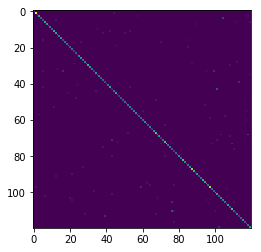

In [114]:
cm = confusion_matrix(xc_valid_preds, valid_batches.classes)
plt.imshow(cm)

In [115]:
write_submission_file(test_probs=xc_test_probs,model_name='Xception', clip_value=0.00)

/home/ubuntu/nbs/dog_breed
